In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from pathlib import Path

In [2]:
data_dir = "../data/evaluation_results"

models = [
    "OLMo-1B-hf",
    "Pleias-1.2b-Preview",
    "gemma-3-1b-pt",
    "gemma-3-1b-it",
    "Llama-3.2-1B",
    "Llama-3.2-1B-Instruct",
    "Llama-3.1-8B",
    "Llama-3.1-8B-Instruct",
    "Llama-3.1-70B",
]

### Prepare Data

Create a dataframe with the results of all models evaluated on original gsm data

In [ ]:
results = []

for folder, language in [
    (f"{data_dir}/gsm_dan", "Danish"),
    (f"{data_dir}/gsm_eng", "English"),
]:
    for file in Path(folder).iterdir():
        if file.suffix == ".csv":
            df = pd.read_csv(file)

            if "correct" in df.columns:
                correct = df["correct"].astype(bool)
                accuracy = round(correct.mean(), 3)
            else:
                print(f"fails: {file}")

            results.append(
                {
                    "model": file.stem,
                    "language": language,
                    "accuracy": accuracy,
                }
            )

df = pd.DataFrame(results)
df.to_csv(f"{data_dir}/results.csv")

### Plot the Evaluated Models on the Original Data

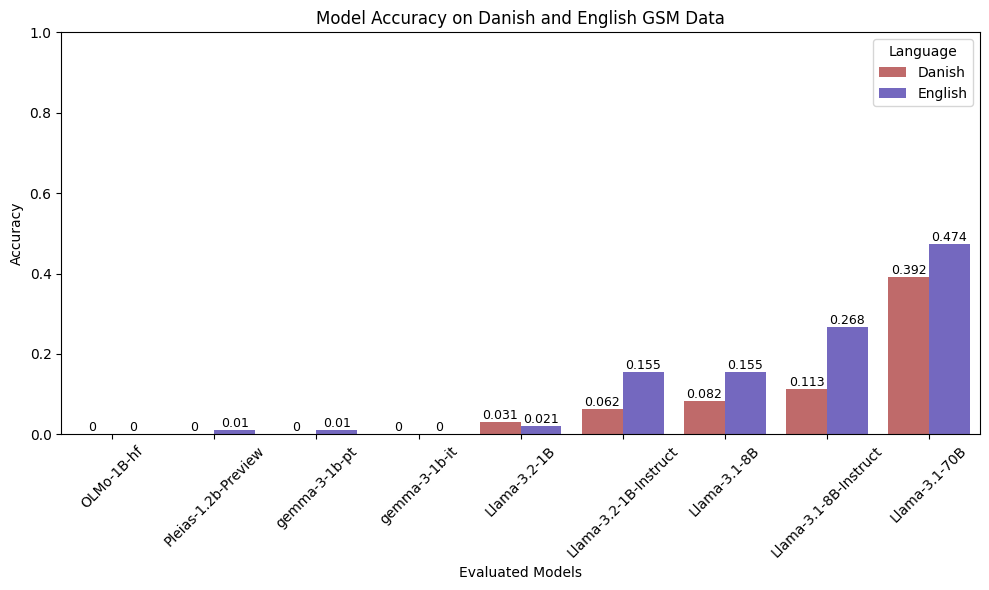

In [5]:
df = pd.read_csv(f"{data_dir}/results.csv")

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    df,
    x="model",
    y="accuracy",
    hue="language",
    palette=["indianred", "slateblue"],
    order=models,
)

for cont in ax.containers:
    ax.bar_label(cont, fontsize=9)

plt.title("Model Accuracy on Danish and English GSM Data")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

plt.xlabel("Evaluated Models")
plt.xticks(rotation=45)

plt.legend(title="Language")

plt.tight_layout()
plt.show()

### Prepare Data

For each model evaluated on the gsm variations, create df with acc scores:

In [ ]:
for folder_path, language in [
    (f"{data_dir}/gsm_dan", "Danish"),
    (f"{data_dir}/gsm_eng", "English"),
]:
    for path in Path(folder_path).iterdir():
        if path.is_dir():
            results = []

            for file in path.iterdir():
                df = pd.read_csv(file)

                correct = df["correct"].astype(bool)
                accuracy = round(correct.mean(), 3)

                results.append(
                    {
                        "model": path.name.replace(".csv", ""),
                        "gsm_var": file.name.split("_")[1].replace(".csv", ""),
                        "language": language,
                        "accuracy": accuracy,
                    }
                )
                df = pd.DataFrame(results)

            df.to_csv(f"{folder_path}/{path.name.replace('.csv', '')}/results.csv")

### Plot the Evaluated Models on the GSM Variats

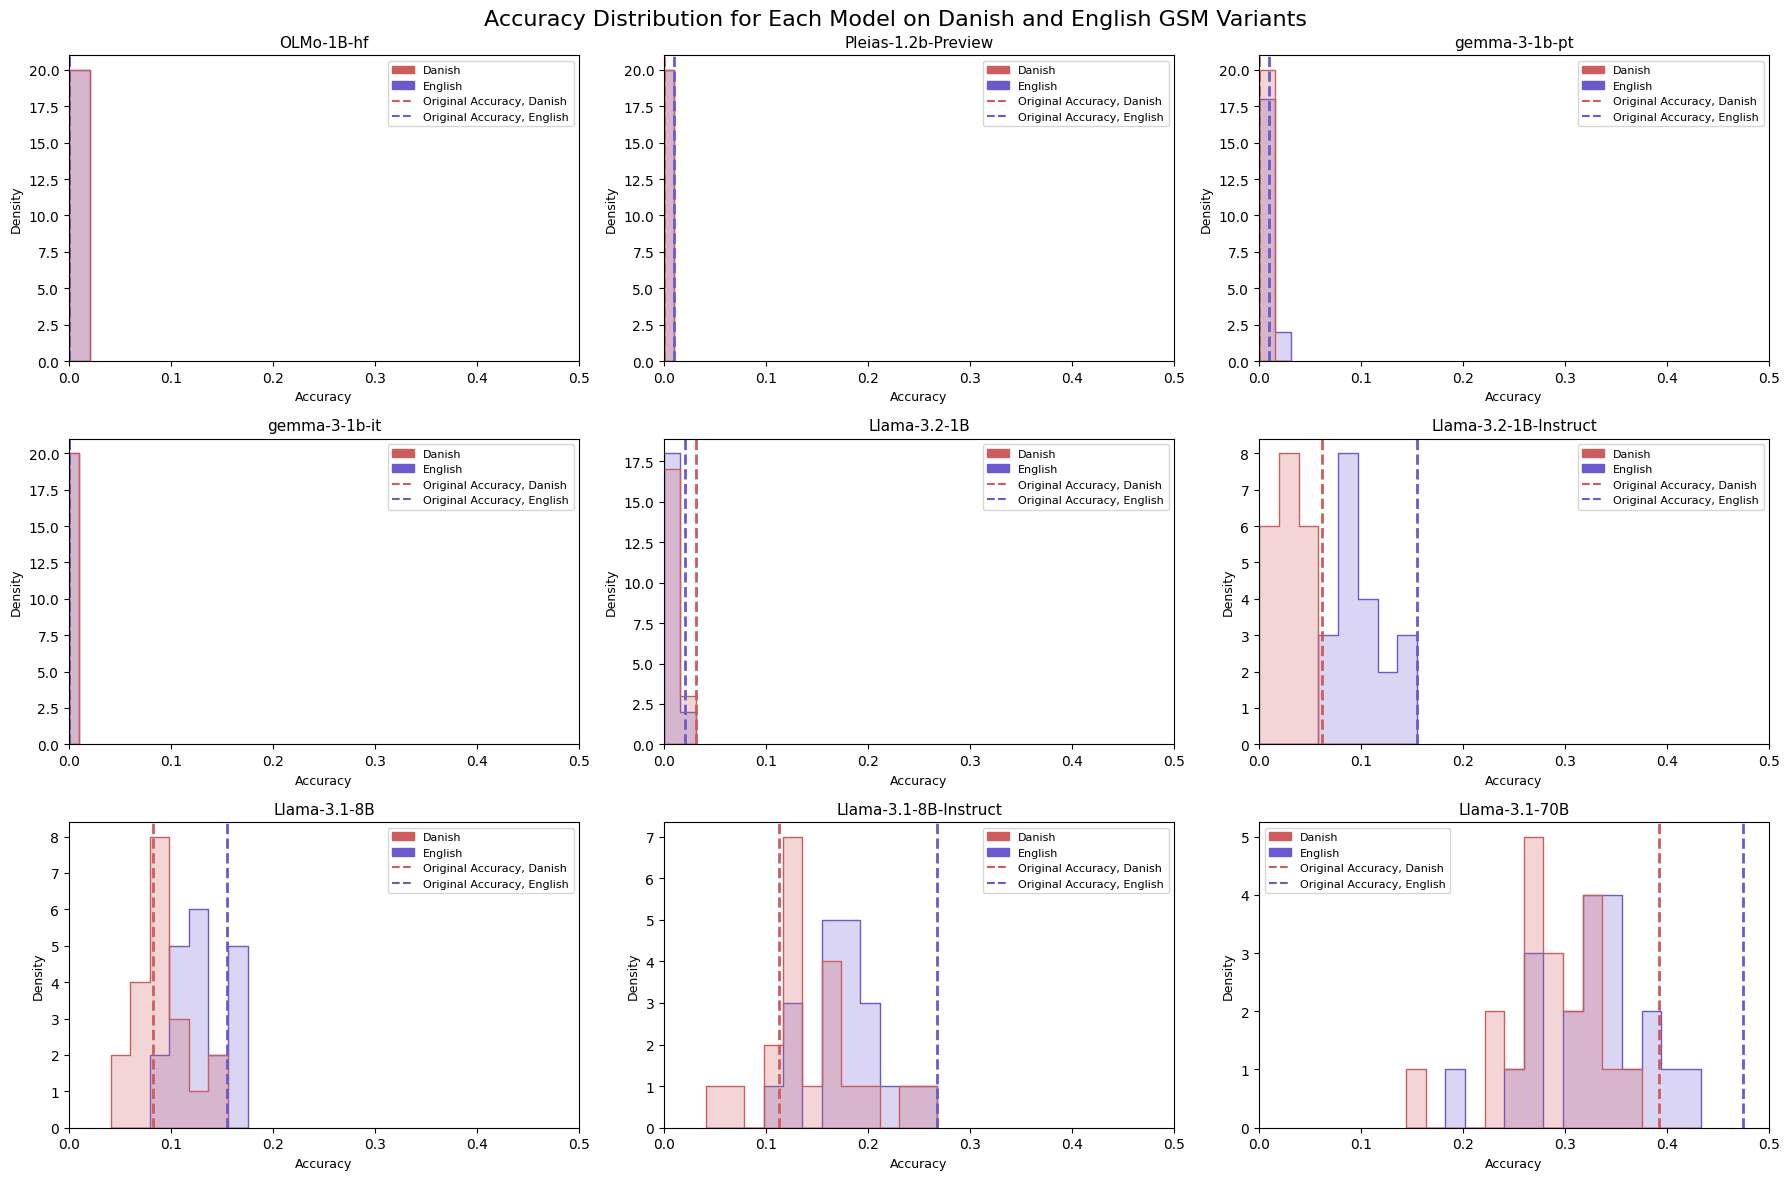

In [15]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axs = axs.flatten()

for idx, model in enumerate(models):
    df_dan = pd.read_csv(f"{data_dir}/gsm_dan/{model}/results.csv")
    df_eng = pd.read_csv(f"{data_dir}/gsm_eng/{model}/results.csv")
    combined = pd.concat([df_dan, df_eng])

    df_org = pd.read_csv(f"{data_dir}/results.csv")
    df_orig_dan = df_org[(df_org["model"] == model) & (df_org["language"] == "Danish")]
    df_orig_eng = df_org[(df_org["model"] == model) & (df_org["language"] == "English")]
    orig_acc_dan = df_orig_dan["accuracy"].iloc[0]
    orig_acc_eng = df_orig_eng["accuracy"].iloc[0]

    ax = axs[idx]
    sns.histplot(
        data=combined,
        x="accuracy",
        hue="language",
        ax=ax,
        palette=["indianred", "slateblue"],
        element="step",
        bins=20,
        binwidth=0.019,
    )
    ax.axvline(
        x=orig_acc_dan,
        color="indianred",
        linestyle="--",
        linewidth=2,
        label="Original Accuracy, Danish",
    )
    ax.axvline(
        x=orig_acc_eng,
        color="slateblue",
        linestyle="--",
        linewidth=2,
        label="Original Accuracy, English",
    )

    danish_patch = mpatches.Patch(color="indianred", label="Danish")
    english_patch = mpatches.Patch(color="slateblue", label="English")
    danish_line = mlines.Line2D(
        [], [], color="indianred", linestyle="--", label="Original Accuracy, Danish"
    )
    english_line = mlines.Line2D(
        [], [], color="slateblue", linestyle="--", label="Original Accuracy, English"
    )

    custom_handles = [danish_patch, english_patch, danish_line, english_line]
    ax.legend(handles=custom_handles, fontsize=8)

    ax.set_title(f"{model}", fontsize=11)
    ax.set_ylabel("Density", fontsize=9)
    ax.set_xlabel("Accuracy", fontsize=9)
    ax.set_xlim(0, 0.5)

plt.suptitle(
    "Accuracy Distribution for Each Model on Danish and English GSM Variants",
    fontsize=16,
)
plt.tight_layout()
plt.show()